In [1]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 6.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
#from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import sys

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime
from statsmodels.tsa.api import VAR

os.chdir('drive/MyDrive/EconML DL/')
sys.path.insert(0, 'Shared')

from varnn_training import *
from sklearn.linear_model import LinearRegression 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

## Loading Data

In [5]:
# 3 variables monthly (currently used June 2022)

data = pd.read_csv('Forecasting/monthlyData.csv')
#data = pd.read_csv('monthlyData_shadow.csv')
data = data.rename(columns = {'Unnamed: 0': 'Date'})
data = data.set_index('Date')
x_d = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d['L0_HOUST'] = x_d['L0_HOUST'].diff()
x_d = x_d.dropna()
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

# Subset the variables we want
x_d = x_d[['inf', 'unrate', 'DGS3', 'house_starts']]
#x_d = x_d[['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate']]
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Load Data - 3-variable Quarterly

data = pd.read_csv('6var_quarterly.csv')
data['DATE'] = data['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data['CPIAUCSL'] = np.log(data['CPIAUCSL'])
data['SP500'] = np.log(data['SP500'])
data['WTISPLC'] = np.log(data['WTISPLC'])
data['EXUSUK'] = np.log(data['EXUSUK'])
data = data.set_index('DATE')
x_d = data.diff().dropna()
# x_d = x_d.iloc[:, [0, 1, 5, 4, 2, 3]]
# x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate']
# x_d_colnames = x_d.columns

x_d = x_d.iloc[:, [4,2,3]]
x_d.columns = ['DGS3', 'Inflation', 'Unrate']
x_d_colnames = x_d.columns
var_names = list(x_d_colnames)
n_var = len(var_names)

In [ ]:
# 7-variables quarterly
data = pd.read_csv('Forecasting/monthlyData.csv')
data['quarter'] = ((data['trend'] ) / 3).astype(int)
data = data.groupby('quarter').mean().reset_index()
data['L0_HOUST'] = data['L0_HOUST'].diff()
data = data.dropna()
x_d = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
x_d_colnames = x_d.columns
var_names = list(x_d_colnames)
n_var = len(var_names)

In [ ]:
# Loading the Data - 7 Variables

#data = pd.read_csv('Forecasting/monthlyData.csv')
data = pd.read_csv('monthlyData_shadow.csv')
x_d = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d['L0_HOUST'] = x_d['L0_HOUST'].diff()
x_d = x_d.dropna()
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

# Subset the variables we want
#x_d = x_d[['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate']]
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Quarterly Data
data = pd.read_csv('6var_quarterly.csv')
data['DATE'] = data['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data['CPIAUCSL'] = np.log(data['CPIAUCSL'])
data['SP500'] = np.log(data['SP500'])
data['WTISPLC'] = np.log(data['WTISPLC'])
data['EXUSUK'] = np.log(data['EXUSUK'])
data = data.set_index('DATE')
x_d = data.diff().dropna()
x_d = x_d.iloc[:, [0, 1, 5, 4, 2, 3]]
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate']
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

## Benchmarks

In [6]:
n_lag_linear = 2
n_lag_d = 8

In [7]:
# 2: Generating the lags
mat_data_d = x_d.copy()

for col in var_names:
  for lag in range(1, n_lag_linear + 1):
    mat_data_d[f'{col}.l{lag}'] = mat_data_d[col].shift(lag)

mat_data_d = mat_data_d.iloc[n_lag_d:, :].reset_index(drop=True)
mat_y_d = mat_data_d.iloc[:, :n_var]
mat_x_d = mat_data_d.iloc[:, n_var:]
mat_x_d_colnames = mat_data_d.iloc[:, n_var:].columns

In [8]:
# Get the index of the lagged values of unemployment rate
first_parts = ['.l' + str(lag) for lag in range(1, n_lag_linear + 1)]

get_xpos = lambda variable_name, first_parts: [list(i for i, n in enumerate(mat_x_d_colnames) if n == variable_name + first_part)[0] for first_part in first_parts]

x_pos = {}
for var in var_names:
  x_pos[var] = get_xpos(var, first_parts)

In [9]:
train_split_id = 641
test_size = 90
X_train = np.array(mat_x_d.iloc[:train_split_id, :])
Y_train = np.array(mat_y_d.iloc[:train_split_id, :])
X_test = np.array(mat_x_d.iloc[train_split_id:(train_split_id) + test_size, :])
Y_test = np.array(mat_y_d.iloc[train_split_id:(train_split_id) + test_size, :])

**Random Forest Benchmark**

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
def conduct_random_forest(X_train, X_test, Y_train, Y_test):

  preds_train = np.zeros_like(Y_train)
  preds_test = np.zeros_like(Y_test)
  
  # Estimate the RF model equation by equation
  for i in range(n_var):
    print(f'Doing variable {i}, time: {datetime.now()}')
    var_name = var_names[i]
    y_train_var = Y_train[:, i]
    X_train_var = X_train[:, x_pos[var_name]]

    rf = RandomForestRegressor(max_depth = 5, random_state = 42, n_estimators = 100, n_jobs = None)
    fit = rf.fit(X_train_var, y_train_var)

    X_test_var = X_test[:, x_pos[var_name]]
    preds_train[:, i] = rf.predict(X_train_var)
    preds_test[:, i] = rf.predict(X_test_var)
  
  return preds_train, preds_test, None

In [12]:
# @title Conduct Regression Function

# Wrapper function to conduct VAR and AR estimation
def conduct_regression(X_train, X_test, Y_train, Y_test, var = True):

  # Do the VAR
  if var == True:
    # Fit the linear regression
    lin_reg = LinearRegression(fit_intercept = True)
    fit = lin_reg.fit(X_train, Y_train)
    # Make in-sample predictions
    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)

    # Return coefs
    coefs = lin_reg.coef_
    intercept = np.expand_dims(lin_reg.intercept_, axis = 1)
    coefs = np.concatenate((intercept, coefs), axis = 1)

  else:
    # Equation-by-equation AR model
    preds_train = np.zeros_like(Y_train)
    preds_test = np.zeros_like(Y_test)

    coefs = np.zeros((n_var, n_var * n_lag_linear + 1))
    
    for i in range(n_var):
      var_name = var_names[i]
      y_train_var = Y_train[:, i]
      X_train_var = X_train[:, x_pos[var_name]]

      lin_reg = LinearRegression(fit_intercept = True)
      fit = lin_reg.fit(X_train_var, y_train_var)

      X_test_var = X_test[:, x_pos[var_name]]
      preds_train[:, i] = lin_reg.predict(X_train_var)
      preds_test[:, i] = lin_reg.predict(X_test_var)

      coefs[i, x_pos[var_name]] = lin_reg.coef_
#      coefs[i, (n_lag_linear*i+1):(n_lag_linear*(i+1)+1)] = lin_reg.coef_
      coefs[i, 0] = lin_reg.intercept_

  return preds_train, preds_test, coefs

In [13]:
# @title Rolling & Expanding window regression


def conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = 40, reestimation_window = 1, window_type = 'roll', var = True):

  # Note: For rolling window: in-sample preds are stored in preds_train_in_all acc to their start id. 
  # For expanding window: end-id

  # In-sample preds for the train set: n_obs x n_var x n_obs (start_t)
  preds_train_in_all = np.zeros((Y_train.shape[0], Y_train.shape[1], Y_train.shape[0]))
  preds_train_in_all[:] = np.nan
  # Out-of-sample preds for the train set (for every window, 'reestimation_window' preds will be predicted)
  preds_train_out = np.zeros_like(Y_train)
  preds_train_out[:] = np.nan
  # Preds for the test set 
  preds_test = np.zeros_like(Y_test)
  preds_test[:] = np.nan

  # Betas for the train set
  betas_all = np.zeros((Y_train.shape[0], Y_train.shape[1], (Y_train.shape[1] * n_lag_linear + 1), Y_train.shape[0]))
  betas_all[:] = np.nan

  for start_t in range(0, Y_train.shape[0] - window_length + 1, reestimation_window):

    end_t = start_t + window_length - 1
    if window_type == 'roll':
      X_train_subset = X_train[start_t:(start_t + window_length), :]
      Y_train_subset = Y_train[start_t:(start_t + window_length), :]
    elif window_type == 'expand':
      X_train_subset = X_train[:(start_t + window_length), :]
      Y_train_subset = Y_train[:(start_t + window_length), :]
    X_train_out_subset = X_train[(start_t + window_length):(start_t + window_length + reestimation_window), :]
    Y_train_out_subset = Y_train[(start_t + window_length):(start_t + window_length + reestimation_window), :]
    # Estimate the model using this window of data
    if start_t == Y_train.shape[0] - window_length:
      preds_train_in_subset, preds_train_out_subset, coefs = conduct_regression(X_train_subset, X_train_subset, Y_train_subset, Y_train_subset, var = var)
    else:
      preds_train_in_subset, preds_train_out_subset, coefs = conduct_regression(X_train_subset, X_train_out_subset, Y_train_subset, Y_train_out_subset, var = var)
      preds_train_out[(start_t + window_length):(start_t + window_length + reestimation_window), :] = preds_train_out_subset
    
    if window_type == 'roll':
      preds_train_in_all[start_t:(start_t + window_length) , :, start_t] = preds_train_in_subset
      betas_all[start_t:(start_t + window_length), :, :, start_t] = coefs
    elif window_type == 'expand':
      preds_train_in_all[:(start_t + window_length) , :, end_t] = preds_train_in_subset
      betas_all[:(start_t + window_length), :, :, end_t] = coefs
    
  # Get the test set preds
  _, preds_test_subset, _ = conduct_regression(X_train_subset, X_test, Y_train_subset, Y_test, var = var)
  preds_test[:] = preds_test_subset[:]

  # Get the in-sample train preds by taking the average of all
  preds_train_in = np.nanmean(preds_train_in_all, axis = 2)

  # Get the Time-varying Coefs by taking average
  betas = np.nanmean(betas_all, axis = 3)

  return preds_train_in, preds_train_out, preds_test, betas

In [14]:
window_length = 80
reestimation_window = 1

# Entire window regression 
preds_train_whole_var, preds_test_whole_var, betas_whole_var = conduct_regression(X_train, X_test, Y_train, Y_test, var = True)
preds_train_whole_ar, preds_test_whole_ar, betas_whole_ar = conduct_regression(X_train, X_test, Y_train, Y_test, var = False)

# Rolling window regression
preds_train_in_roll_var, _, preds_test_roll_var, betas_roll_var = conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = window_length, reestimation_window = reestimation_window, window_type = 'roll', var = True)
preds_train_in_roll_ar, _, preds_test_roll_ar, betas_roll_ar = conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = window_length, reestimation_window = reestimation_window, window_type = 'roll', var = False)

# Expanding window regression
preds_train_in_expand_var, _, preds_test_expand_var, betas_expand_var = conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = window_length, reestimation_window = reestimation_window, window_type = 'expand', var = True)
preds_train_in_expand_ar, _, preds_test_expand_ar, betas_expand_ar = conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = window_length, reestimation_window = reestimation_window, window_type = 'expand', var = False)

# Random forest
preds_train_whole_rf, preds_test_whole_rf, _ = conduct_random_forest(X_train, X_test, Y_train, Y_test)

Doing variable 0, time: 2022-06-20 21:54:54.739270
Doing variable 1, time: 2022-06-20 21:54:55.024329
Doing variable 2, time: 2022-06-20 21:54:55.276722
Doing variable 3, time: 2022-06-20 21:54:55.539711


In [15]:
# Expanding the entire-window regression coefs to be same shape as the rolling/expanding window

betas_whole_var = np.repeat(np.expand_dims(betas_whole_var, axis = 0), betas_expand_var.shape[0], axis = 0)
betas_whole_ar = np.repeat(np.expand_dims(betas_whole_ar, axis = 0), betas_expand_ar.shape[0], axis = 0)

**Tuning Optimal Window Size**

In [ ]:
# Test which window is the best

errors = []
window_sizes = list(range(30, 150, 2))
reestimation_window = 1

for window_length in window_sizes:
  print(window_length)
  preds_train_in_roll_var, _, preds_test_roll_var, betas_roll_var = conduct_window_regression(X_train, X_test, Y_train, Y_test, window_length = window_length, reestimation_window = reestimation_window, window_type = 'roll', var = True)
  error = np.sum(np.abs(preds_test_roll_var - Y_test), axis = 0)
  print(error)
  errors.append(error)

In [ ]:
errors_mat = np.vstack(errors)
errors_mat = errors_mat / errors_mat[0, :]

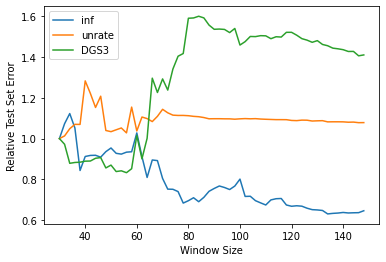

In [ ]:
fig, ax = plt.subplots()
for i in range(n_var):
  ax.plot(window_sizes, errors_mat[:, i], label = var_names[i])
ax.set_xlabel('Window Size')
ax.set_ylabel('Relative Test Set Error')
ax.legend()

In [17]:
# Save the Experiment Results

experiment_name = '20jun_jointestimation'
folder_path = f'2022 Experiments/{experiment_name}'
# Create image folder if not exist yet
benchmark_folder_path = f'{folder_path}/benchmarks'
if os.path.isdir(benchmark_folder_path) == False:
  os.mkdir(benchmark_folder_path)

savefile_header = '4var_'

with open(f'{benchmark_folder_path}/{savefile_header}benchmark_VAR_whole.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_whole_var, betas_in = betas_whole_var, test_preds = preds_test_whole_var, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_AR_whole.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_whole_ar, betas_in = betas_whole_ar, test_preds = preds_test_whole_ar, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_VAR_roll.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_in_roll_var, betas_in = betas_roll_var, test_preds = preds_test_roll_var, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_AR_roll.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_in_roll_ar, betas_in = betas_roll_ar, test_preds = preds_test_roll_ar, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_VAR_expand.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_in_expand_var, betas_in = betas_expand_var, test_preds = preds_test_expand_var, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_AR_expand.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_in_expand_ar, betas_in = betas_expand_ar, test_preds = preds_test_expand_ar, y = Y_train, y_test = Y_test)
with open(f'{benchmark_folder_path}/{savefile_header}benchmark_RF_whole.npz', 'wb') as f:
  np.savez(f, train_preds = preds_train_whole_rf, test_preds = preds_test_whole_rf, y = Y_train, y_test = Y_test)